# Model training and selection

In [1]:
import pickle
from tqdm.notebook import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn

import time

In [2]:
name = "testing_data_set_x10"

with open(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/datasets/{name}.obj", 'rb') as f:
    data_set = pickle.load(f)

In [3]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
  global net, loss_function, scheduler, optimizer
  
  net = torchvision.models.resnet18(pretrained=True).to(device)

  #net = torchvision.models.densenet121(pretrained=True).to(device)
      
  for param in net.parameters():
      param.requires_grad = False # Freezing the convolutional layers
      
  net.fc = nn.Sequential(
                nn.Linear(512, 128), #512
                nn.ReLU(inplace=True),
                nn.Linear(128, 2),
                nn.Softmax(dim = -1)
                ).to(device)

  net.fc.apply(init_weights) # Xavier init

  # resnet.fc = torch.load("") # Model loading

  print("Number of free parameters on fc layer: ", sum(p.numel() for p in net.fc.parameters()))

  #Hyperparameters:
  learning_rate = 0.001 # LR
  loss_function = nn.BCELoss()
  # Loss # [1,0] es positivo y [0,1] negativo # weight = torch.tensor([(495+201)/(2*495), (201+495)/(2*201)]).to(device)) # El negativo cuesta 2.5... mas
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)# Optimizer
  lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

init()

Number of free parameters on fc layer:  65922


In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()

    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    conf_m = confusion_matrix( [torch.argmax(i) for i in y.cpu()],[torch.argmax(i) for i in outputs.cpu()], labels=(0, 1))
    f1 = conf_m[0][0]/(conf_m[0][0]+0.5*(conf_m[1][0]+conf_m[0][1]))
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    del outputs

    return acc, loss, f1

In [6]:
def validate(val_X, val_y, size=32):
# Hago un test con datos en una región aleatoria para que la distribución sea mejor
  val_X, val_y = shuffle(val_X, val_y) 
  
  if size > 0.7*len(val_y):
    ramdom_start = 0
  else:
    ramdom_start = np.random.randint(len(val_X)-size)

  X, y = val_X[ramdom_start:ramdom_start+size].to(device), val_y[ramdom_start:ramdom_start+size].to(device)
  val_acc, val_loss, val_f1 = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y, train=False)
  del X, y

  return val_acc, val_loss, val_f1 # accuracy y loss en validation set

In [7]:
def test():
# Hago un test con datos en una región aleatoria para que la distribución sea mejor
  X, y = test_X.to(device), test_y.to(device)
  test_acc, test_loss = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y)
  del X, y

  return test_acc, test_loss # accuracy y loss en test set

In [8]:
def shuffle(X, y): # Esta función debería hacer un shuffle del data set sin desordenar las etiquetas
  c = list(zip(X, y))
  random.shuffle(c)
  X, y = zip(*c)
  return torch.stack(X), torch.stack(y)

In [9]:
%%time

patch_size = 300

SIZE_X = patch_size
SIZE_Y = patch_size

MODE = "a"
MODEL_NAME = "ejemplo"

def train():

  global net, loss_function, scheduler, optimizer, train_X, train_y, MODEL_NAME

  print(MODEL_NAME)
  BATCH_SIZE = 16
  EPOCHS = 35

  N_BATCHES = len(range(0, len(train_X), BATCH_SIZE))
  N_BATCHES_VAL = len(range(0, len(val_X), BATCH_SIZE))
  
  with open("C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1 = 0, 0, 0
      val_acc, val_loss, val_f1 = 0, 0, 0

      train_X, train_y = shuffle(train_X, train_y)

      print("\nEPOCH: ", epoch+1)

      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,3,SIZE_X,SIZE_Y).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        
        net.train() # Making sure that the model is in training mode
        
        acc_aux, loss_aux, f1_aux = fwd_pass(batch_X, batch_y, train=True)
        
        acc += acc_aux/N_BATCHES # Calculating the average loss and acc trough batches
        loss += loss_aux/N_BATCHES
        f1 += f1_aux/N_BATCHES

        del batch_X, batch_y
      '''
      for i in tqdm(range(0, int(len(val_X)*0.2), BATCH_SIZE)):
        net.eval() # Making sure that the model is not training and deactivate droptout
        
        val_acc_aux, val_loss_aux = validate(val_X, val_y, size=BATCH_SIZE)
      
        val_acc += val_acc_aux/N_BATCHES_VAL # Calculating the average loss and acc trough batches
        val_loss += val_loss_aux/N_BATCHES_VAL
      '''

      val_acc, val_loss, val_f1 = validate(val_X, val_y, size=len(val_y))

      print("Val loss: ", val_loss.item()," Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc," Train acc: ", acc, "\n")
      print("Val f1: ", val_f1," Train f1: ", f1, "\n")

      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{round(float(val_acc),3)},{round(float(val_loss),4)}\n")
      f.write("\n\n")

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

    torch.save(net.fc, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")


CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
# Choosing only the images from the according splits (10CV)

for SPLIT in range(1):
    MODEL_NAME = f"ejemplo_{SPLIT}"

    train_idx = []
    val_idx = []

    TRAIN_SPLIT = open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\splits\\trainsplit{SPLIT}.txt", "r").read().split()
    VAL_SPLIT = open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\splits\\testsplit{SPLIT}.txt", "r").read().split()

    for i, case in enumerate(data_set.case_ids):
        if case in TRAIN_SPLIT:
            train_idx.append(i)
        elif case in VAL_SPLIT:
            val_idx.append(i)

    X, y = data_set.inputs.float(), data_set.labels.float()

    train_X, train_y = shuffle(torch.stack([X[i] for i in train_idx]), torch.stack([y[i] for i in train_idx]))

    val_X, val_y = shuffle(torch.stack([X[i] for i in val_idx]), torch.stack([y[i] for i in val_idx]))

    train()


ejemplo_0

EPOCH:  1


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.6642974615097046  Train loss:  0.28301531076431274 

Val acc:  0.7015384615384616  Train acc:  0.8836984536082454 

Val f1:  0.8245931283905967  Train f1:  0.906849142100899 

Learning Rate:  0.001

EPOCH:  2


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3550471365451813  Train loss:  0.14911825954914093 

Val acc:  0.8615384615384616  Train acc:  0.9458762886597916 

Val f1:  0.9256198347107438  Train f1:  0.9599942918865819 

Learning Rate:  0.0008

EPOCH:  3


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3583822250366211  Train loss:  0.1065594032406807 

Val acc:  0.84  Train acc:  0.9613402061855647 

Val f1:  0.9130434782608695  Train f1:  0.9704173063165634 

Learning Rate:  0.0006400000000000002

EPOCH:  4


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.42000338435173035  Train loss:  0.10140324383974075 

Val acc:  0.8092307692307692  Train acc:  0.9629510309278327 

Val f1:  0.8945578231292517  Train f1:  0.9707168102660219 

Learning Rate:  0.0005120000000000001

EPOCH:  5


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.6155648231506348  Train loss:  0.08887180685997009 

Val acc:  0.7230769230769231  Train acc:  0.9658505154639152 

Val f1:  0.8392857142857143  Train f1:  0.9734614206617881 

Learning Rate:  0.0004096000000000001

EPOCH:  6


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3534905016422272  Train loss:  0.07253684103488922 

Val acc:  0.8461538461538461  Train acc:  0.9722938144329873 

Val f1:  0.9166666666666666  Train f1:  0.9784128418625238 

Learning Rate:  0.0003276800000000001

EPOCH:  7


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.16657651960849762  Train loss:  0.05959482863545418 

Val acc:  0.9323076923076923  Train acc:  0.9835695876288636 

Val f1:  0.964968152866242  Train f1:  0.987775199383239 

Learning Rate:  0.0002621440000000001

EPOCH:  8


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.6509854793548584  Train loss:  0.05031716451048851 

Val acc:  0.7107692307692308  Train acc:  0.98324742268041 

Val f1:  0.8309352517985612  Train f1:  0.9864184966265602 

Learning Rate:  0.0002097152000000001

EPOCH:  9


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.2518346309661865  Train loss:  0.04873877018690109 

Val acc:  0.8892307692307693  Train acc:  0.9845360824742244 

Val f1:  0.9413680781758957  Train f1:  0.9883791469654001 

Learning Rate:  0.0001677721600000001

EPOCH:  10


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3165152072906494  Train loss:  0.048189423978328705 

Val acc:  0.8676923076923077  Train acc:  0.9845360824742244 

Val f1:  0.929159802306425  Train f1:  0.9872951158646924 

Learning Rate:  0.00013421772800000008

EPOCH:  11


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.45474645495414734  Train loss:  0.04616985097527504 

Val acc:  0.7907692307692308  Train acc:  0.9867912371133997 

Val f1:  0.8831615120274914  Train f1:  0.9884956458469679 

Learning Rate:  0.00010737418240000006

EPOCH:  12


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.35644540190696716  Train loss:  0.04013403132557869 

Val acc:  0.8369230769230769  Train acc:  0.9880798969072141 

Val f1:  0.9112227805695142  Train f1:  0.9900575122430519 

Learning Rate:  8.589934592000005e-05

EPOCH:  13


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.22306373715400696  Train loss:  0.03974045813083649 

Val acc:  0.9076923076923077  Train acc:  0.9884020618556677 

Val f1:  0.9516129032258065  Train f1:  0.9906687314762564 

Learning Rate:  6.871947673600005e-05

EPOCH:  14


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.30975037813186646  Train loss:  0.04065806418657303 

Val acc:  0.8676923076923077  Train acc:  0.9871134020618533 

Val f1:  0.929159802306425  Train f1:  0.9896518425271564 

Learning Rate:  5.497558138880004e-05

EPOCH:  15


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.29683998227119446  Train loss:  0.03612663596868515 

Val acc:  0.88  Train acc:  0.9871134020618533 

Val f1:  0.9361702127659575  Train f1:  0.9901611842965841 

Learning Rate:  4.398046511104004e-05

EPOCH:  16


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.34452101588249207  Train loss:  0.03826473280787468 

Val acc:  0.8523076923076923  Train acc:  0.9874355670103069 

Val f1:  0.920265780730897  Train f1:  0.9889021887967622 

Learning Rate:  3.518437208883203e-05

EPOCH:  17


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.48291894793510437  Train loss:  0.039883650839328766 

Val acc:  0.7753846153846153  Train acc:  0.9880798969072141 

Val f1:  0.8734835355285961  Train f1:  0.9905027841332075 

Learning Rate:  2.8147497671065623e-05

EPOCH:  18


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.40954890847206116  Train loss:  0.04112967103719711 

Val acc:  0.8123076923076923  Train acc:  0.9887242268041213 

Val f1:  0.8964346349745331  Train f1:  0.9899487506790742 

Learning Rate:  2.2517998136852502e-05

EPOCH:  19


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3085867166519165  Train loss:  0.04333440586924553 

Val acc:  0.8707692307692307  Train acc:  0.9858247422680388 

Val f1:  0.930921052631579  Train f1:  0.9887771219539495 

Learning Rate:  1.8014398509482003e-05

EPOCH:  20


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.45038875937461853  Train loss:  0.035874027758836746 

Val acc:  0.8  Train acc:  0.9880798969072141 

Val f1:  0.8888888888888888  Train f1:  0.9900004131732925 

Learning Rate:  1.4411518807585603e-05

EPOCH:  21


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.30681419372558594  Train loss:  0.03676317632198334 

Val acc:  0.8738461538461538  Train acc:  0.9903350515463893 

Val f1:  0.9326765188834154  Train f1:  0.992781837013331 

Learning Rate:  1.1529215046068483e-05

EPOCH:  22


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3440797030925751  Train loss:  0.031023511663079262 

Val acc:  0.8492307692307692  Train acc:  0.9916237113402038 

Val f1:  0.9184692179700499  Train f1:  0.9930501919195655 

Learning Rate:  9.223372036854787e-06

EPOCH:  23


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.333608478307724  Train loss:  0.03584111109375954 

Val acc:  0.8615384615384616  Train acc:  0.9877577319587605 

Val f1:  0.9256198347107438  Train f1:  0.9898868243273496 

Learning Rate:  7.37869762948383e-06

EPOCH:  24


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.34680280089378357  Train loss:  0.03510237857699394 

Val acc:  0.8492307692307692  Train acc:  0.990657216494843 

Val f1:  0.9184692179700499  Train f1:  0.9921898826978259 

Learning Rate:  5.902958103587064e-06

EPOCH:  25


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3396192491054535  Train loss:  0.0332195870578289 

Val acc:  0.8584615384615385  Train acc:  0.9909793814432966 

Val f1:  0.9238410596026491  Train f1:  0.9929501116625524 

Learning Rate:  4.722366482869652e-06

EPOCH:  26


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.34724360704421997  Train loss:  0.03892712667584419 

Val acc:  0.8492307692307692  Train acc:  0.9900128865979357 

Val f1:  0.9184692179700499  Train f1:  0.9916423226776494 

Learning Rate:  3.7778931862957216e-06

EPOCH:  27


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3451686501502991  Train loss:  0.032813552767038345 

Val acc:  0.8492307692307692  Train acc:  0.990657216494843 

Val f1:  0.9184692179700499  Train f1:  0.9930004635618805 

Learning Rate:  3.0223145490365774e-06

EPOCH:  28


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.32962363958358765  Train loss:  0.03636034205555916 

Val acc:  0.8584615384615385  Train acc:  0.9877577319587605 

Val f1:  0.9238410596026491  Train f1:  0.9902237553672621 

Learning Rate:  2.417851639229262e-06

EPOCH:  29


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.316098153591156  Train loss:  0.03053879551589489 

Val acc:  0.8707692307692307  Train acc:  0.9925902061855646 

Val f1:  0.930921052631579  Train f1:  0.9942797614219284 

Learning Rate:  1.93428131138341e-06

EPOCH:  30


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.32987257838249207  Train loss:  0.0315614752471447 

Val acc:  0.8584615384615385  Train acc:  0.9916237113402038 

Val f1:  0.9238410596026491  Train f1:  0.9929889867537648 

Learning Rate:  1.547425049106728e-06

EPOCH:  31


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3423908054828644  Train loss:  0.04041684791445732 

Val acc:  0.8523076923076923  Train acc:  0.9867912371133997 

Val f1:  0.920265780730897  Train f1:  0.9889354251838705 

Learning Rate:  1.2379400392853823e-06

EPOCH:  32


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.35335445404052734  Train loss:  0.037499770522117615 

Val acc:  0.8492307692307692  Train acc:  0.9887242268041213 

Val f1:  0.9184692179700499  Train f1:  0.9910117478507008 

Learning Rate:  9.903520314283058e-07

EPOCH:  33


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3491693139076233  Train loss:  0.03197460249066353 

Val acc:  0.8492307692307692  Train acc:  0.9932345360824718 

Val f1:  0.9184692179700499  Train f1:  0.9943190703280483 

Learning Rate:  7.922816251426449e-07

EPOCH:  34


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.347162663936615  Train loss:  0.0415043979883194 

Val acc:  0.8492307692307692  Train acc:  0.9867912371133997 

Val f1:  0.9184692179700499  Train f1:  0.989528659068354 

Learning Rate:  6.338253001141158e-07

EPOCH:  35


  0%|          | 0/194 [00:00<?, ?it/s]

Val loss:  0.3452383279800415  Train loss:  0.03436000272631645 

Val acc:  0.8492307692307692  Train acc:  0.9903350515463893 

Val f1:  0.9184692179700499  Train f1:  0.9922324388847971 

Learning Rate:  5.070602400912927e-07


In [11]:
def learning_curve():
  fig, axs = plt.subplots(2, figsize = (7,6))

  acc_df = pd.read_csv("C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model.log")
  acc_df.columns = ["MODEL_NAME", "TIME", "ACC", "LOSS", "VAL_ACC", "VAL_LOSS"]

  fig, axs = plt.subplots(2, figsize=(5,7))
  #ax = plt.gca() # GET CURRENT AXIS

  axs[0].legend("MODEL_NAME", loc=2)

  acc_df.plot(y="ACC", ax=axs[0])
  acc_df.plot(y="VAL_ACC", ax=axs[0])

  acc_df.plot(y="LOSS", ax=axs[1])
  acc_df.plot(y="VAL_LOSS",ax=axs[1])

  fig.show()
  fig.savefig(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\lc\\l_curve_{MODEL_NAME}.pdf")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18312\440877980.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


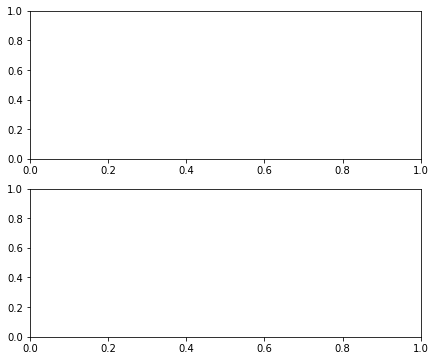

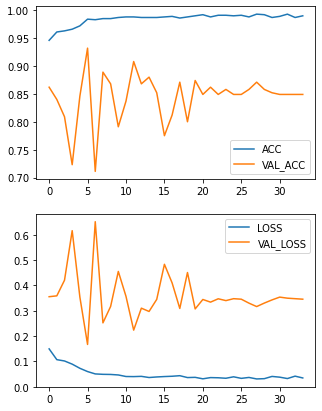

In [12]:
learning_curve()